TESTING FEATURE ENGINEERING AND LOGISTIC REGRESSION:

1 ==All data points==
a) All features
b) Only pre-processed features
c) Only raw features

2 ==Removing outliers==
a) All features
b) Only pre-processed features
c) Only raw features

3 ==Removing the features with more than 70% missing values==
a) All features
b) Only pre-processed features
c) Only raw features

4 ==Removing the features with more than 30% missing values==
a) All features
b) Only pre-processed features
c) Only raw features


TAKE THE BEST SCORE OF THOSE AND TRY FEATURE ENGINEERING WITH THIS SET

Skewness transformation
Removing one item from correlated pairs of features



In [1]:
import numpy as np
import p1lib.p1lib as ml
import proj1_helpers
from Unas_code import functions as unatools
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
y, X, ids=proj1_helpers.load_csv_data('train.csv')
y=np.expand_dims(y, axis=1)
y[y==-1]=0
x,_,__=ml.standardise(X)
tx=ml.augment_data(np.array(x))

In [3]:
#Split data between training and test
x_train, y_train, x_test, y_test=ml.split_data(tx, y, 0.8, seed=42)

In [4]:
#DEFINE A FUNCTION THAT DIRECTLY CALCULATES THE SCORE
def predictionToClassesLogistic(y):
    y=y-0.5
    y=np.ceil(y)
    return y.astype(int)

def calculate_classification_accuracy(y, tx, w):
    y_pred=np.dot(tx,w)
    y_pred=ml.sigmoid(y_pred)
    class_pred=predictionToClassesLogistic(y_pred)
    class_pred[class_pred==0]=-1
    y[y==0]=-1
    compare=np.squeeze(class_pred*y)
    hits=np.sum(compare[compare==1])
    misses=-np.sum(compare[compare==-1])
    accuracy=hits/(hits+misses)
    return accuracy

In [5]:
k_fold=4


def crossval(x, y, kfold, lambda_, gamma, w_ini, max_iter, seed, batch_size):
    k_indices=ml.build_k_indices(y, k_fold, seed=seed)
    all_indices = np.arange(len(y))
    x_tr=[]
    y_tr=[]
    x_te=[]
    y_te=[]
    for k in range(k_fold):
        test_indices = k_indices[k]
        train_indices = [i for i in all_indices if i not in test_indices]
        x_te.append(x[test_indices])
        y_te.append(y[test_indices])
        x_tr.append(x[train_indices])
        y_tr.append(y[train_indices])


    tr_scores = []
    te_scores = []
    for k in range(k_fold):

            
        w_tr, _=ml.reg_logistic_regression(y_tr[k], x_tr[k], lambda_, w_ini, max_iter, gamma)
        #w_tr, _=ml.stochastic_reg_logistic_regression(y_tr[k], x_tr[k], lambda_, w_ini, max_iter, gamma, batch_size)
        #w_tr, _=ml.logistic_regression(y_tr, x_tr, w_ini, max_iter, gamma)

        tr_score=calculate_classification_accuracy(y_tr[k], x_tr[k], w_tr)
        te_score=calculate_classification_accuracy(y_te[k], x_te[k], w_tr)
            
        tr_scores.append(tr_score)
        te_scores.append(te_score)
            
    mean_tr_score=np.mean(tr_scores)
    mean_te_score=np.mean(te_scores)
    print('lambda: %f, gamma: %f, training score: %f, test score: %f' %(lambda_,gamma, mean_tr_score, mean_te_score))
    return mean_te_score, mean_tr_score


def crossval_grid(x_train, y_train, x_test, y_test, kfold, lambdas, gammas, w_ini, max_iter, seed, batch_size):
    gs=[]
    ls=[]
    scores=[]
    train_scoremap=np.zeros((len(lambdas), len(gammas)))
    test_scoremap=np.zeros((len(lambdas), len(gammas)))
    i=0
 
    for l in lambdas:
        j=0
        for g in gammas:
            print('lambda: %f, opt. gamma: %f' %(l, g))
            gs.append(g)
            ls.append(l)
            te_score, tr_score=crossval(x_train, y_train, kfold, l, g, w_ini, max_iter, seed, batch_size)
            scores.append(te_score)
            train_scoremap[i,j]=tr_score
            test_scoremap[i,j]=te_score
            j+=1
        i+=1
    opt_g, opt_l, best_score=gs[np.argmax(scores)], ls[np.argmax(scores)], np.max(scores)
    print('Crossvalidation best score: %f, opt. lambda: %f, opt. gamma: %f' %(best_score, opt_l, opt_g))
    opt_weights,_=ml.reg_logistic_regression(y_train, x_train, opt_l, w_ini, max_iter, opt_g)
    #opt_weights, _=ml.logistic_regression(y_train, x_train, w_ini, max_iter, opt_g)
    #opt_weights, _=ml.stochastic_reg_logistic_regression(y_train, x_train, opt_l, w_ini, max_iter, opt_g, batch_size)

    
    #train_score=calculate_classification_accuracy(y_train, x_train, opt_weights)
    test_score=calculate_classification_accuracy(y_test, x_test, opt_weights)
    
    
    plt.subplot(211)
    plt.contourf(gammas, lambdas, train_scoremap)
    plt.xlabel('gamma')
    plt.ylabel('lambda')
    plt.colorbar()
    plt.subplot(212)
    plt.contourf(gammas, lambdas, test_scoremap)
    plt.xlabel('gamma')
    plt.ylabel('lambda')
    plt.colorbar()
    plt.show()
    
    print('Test score for optimised parameters: %f' %test_score)
    return opt_l, opt_g, test_score    

lambda: 0.000000, opt. gamma: 0.050000
Current iteration=0, loss=0.6931471605599454
Current iteration=100, loss=0.5457438584273734
Current iteration=200, loss=0.5264198165557732
Current iteration=300, loss=0.5187104433864341
Current iteration=400, loss=0.5140716633845258
Current iteration=500, loss=0.5106945675513556
Current iteration=600, loss=0.508021852605996
Current iteration=700, loss=0.5058232865268537
Current iteration=800, loss=0.5039774626615167
Current iteration=900, loss=0.5024080426519524
Current iteration=1000, loss=0.5010615244288201
Current iteration=1100, loss=0.49989801014687246
Current iteration=0, loss=0.6931471605599454
Current iteration=100, loss=0.5499881107293877
Current iteration=200, loss=0.5317016004560129
Current iteration=300, loss=0.5244543229317087
Current iteration=400, loss=0.5200811071952877
Current iteration=500, loss=0.5168953404636122
Current iteration=600, loss=0.514383206508072
Current iteration=700, loss=0.5123290880824284
Current iteration=800, l

Current iteration=0, loss=0.6931471605599454
Current iteration=100, loss=0.539514885929478
Current iteration=200, loss=0.5329252845369319
Current iteration=300, loss=0.5308085367229637
Current iteration=0, loss=0.6931471605599454
Current iteration=100, loss=0.54420182622132
Current iteration=200, loss=0.5379826707400521
Current iteration=300, loss=0.5359843162341378
Current iteration=0, loss=0.6931471605599454
Current iteration=100, loss=0.5407290890935549
Current iteration=200, loss=0.5345593993634273
Current iteration=300, loss=0.5326226051098861
Current iteration=0, loss=0.6931471605599454
Current iteration=100, loss=0.5409548370687327
Current iteration=200, loss=0.5345938278037022
Current iteration=300, loss=0.5325579363572778
lambda: 0.010000, gamma: 0.100000, training score: 0.742367, test score: 0.739800
lambda: 0.010000, opt. gamma: 0.250000
Current iteration=0, loss=0.6931471605599454
Current iteration=100, loss=0.5316189180675198
Current iteration=0, loss=0.6931471605599454
C

Current iteration=1000, loss=0.7505096365354935
Current iteration=1100, loss=0.7505096365354935
Current iteration=1200, loss=0.7505096365354935
Current iteration=1300, loss=0.7505096365354935
Current iteration=1400, loss=0.7505096365354935
Current iteration=0, loss=0.6931471605599454
Current iteration=100, loss=0.7597052444168367
Current iteration=200, loss=0.7597052210622238
Current iteration=300, loss=0.7597052210620102
Current iteration=400, loss=0.7597052210620102
Current iteration=500, loss=0.7597052210620101
Current iteration=600, loss=0.7597052210620101
Current iteration=700, loss=0.7597052210620101
Current iteration=800, loss=0.7597052210620101
Current iteration=900, loss=0.7597052210620101
Current iteration=1000, loss=0.7597052210620101
Current iteration=1100, loss=0.7597052210620101
Current iteration=1200, loss=0.7597052210620101
Current iteration=1300, loss=0.7597052210620101
Current iteration=1400, loss=0.7597052210620101
Current iteration=0, loss=0.6931471605599454
Current

Current iteration=0, loss=0.6931471605599454
Current iteration=100, loss=0.8706175647812181
Current iteration=200, loss=0.8706175647812038
Current iteration=300, loss=0.870617564781204
Current iteration=400, loss=0.870617564781204
Current iteration=500, loss=0.870617564781204
Current iteration=600, loss=0.870617564781204
Current iteration=700, loss=0.870617564781204
Current iteration=800, loss=0.870617564781204
Current iteration=900, loss=0.870617564781204
Current iteration=1000, loss=0.870617564781204
Current iteration=1100, loss=0.870617564781204
Current iteration=1200, loss=0.870617564781204
Current iteration=1300, loss=0.870617564781204
Current iteration=1400, loss=0.870617564781204
lambda: 0.100000, gamma: 1.000000, training score: 0.538600, test score: 0.539000
Crossvalidation best score: 0.749300, opt. lambda: 0.000000, opt. gamma: 0.750000
Current iteration=0, loss=0.6931471605599451
Current iteration=100, loss=0.500333176787253
Current iteration=200, loss=0.49604901729408646


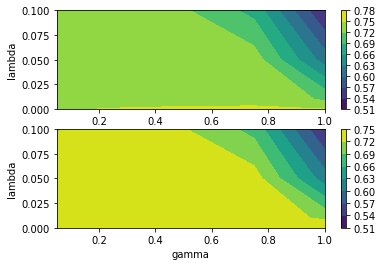

Test score for optimised parameters: 0.750100


(0.0, 0.75, 0.7501)

In [6]:
sampsize=10000
x_toy_tr=x_train[:sampsize,:]
y_toy_tr=y_train[:sampsize,:]
x_toy_te=x_test[:sampsize,:]
y_toy_te=y_test[:sampsize,:]
#lambdas=np.array([0, 0.05, 0.1, 0.5, 1, 1.5])
lambdas=np.array([0, 0.01, 0.05, 0.1])
gammas=np.array([0.05, 0.1, 0.25, 0.5, 0.75, 1])
w_ini=np.zeros((x_toy_tr.shape[1],1))
crossval_grid(x_toy_tr, y_toy_tr, x_toy_te, y_toy_te, 4, lambdas, gammas, w_ini, 1500, 42, 20)

lambda: 0.000000, opt. gamma: 0.100000
Current iteration=0, loss=0.6931471605599454
Current iteration=100, loss=0.5327855557850758
Current iteration=200, loss=0.5208514935586713
Current iteration=300, loss=0.5149315251221098
Current iteration=400, loss=0.511005906437574
Current iteration=500, loss=0.5082156913605026
Current iteration=600, loss=0.5061656769478793
Current iteration=700, loss=0.5046245219629704
Current iteration=800, loss=0.5034450472049325
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.5314263731990185
Current iteration=200, loss=0.5194832312923232
Current iteration=300, loss=0.5135738810494963
Current iteration=400, loss=0.5096809022339907
Current iteration=500, loss=0.5069195866949966
Current iteration=600, loss=0.5048835550957849
Current iteration=700, loss=0.5033482137951738
Current iteration=800, loss=0.5021704758758424
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.530858902327154
Current iteration=200, loss=0

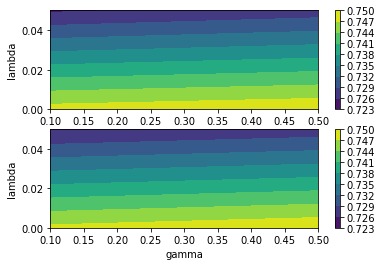

Test score for optimised parameters: 0.748760


(0.0, 0.5, 0.74876)

In [7]:
lambdas=np.array([0, 0.05])
gammas=np.array([0.1, 0.5])
w_ini=np.zeros((x_train.shape[1],1))
crossval_grid(x_train, y_train, x_test, y_test, 4, lambdas, gammas, w_ini, 1000, 42, 50)

In [8]:
#w_ini=np.zeros((tx.shape[1],1))
#lambdas=np.logspace(-6,0, num=7)
#lambdas=np.array([0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5])
#lambda_opt, score=crossval_lambda(x_train, y_train, 4, lambdas, 1e-2, w_ini, 1000, 42)

In [9]:
#print('lambda opt: %f' %lambda_opt)
#gammas=np.logspace(-6, -2, num=5)
#gammas=np.array([0.005, 0.01, 0.025, 0.05])
#gamma_opt, score=crossval_gamma(x_train, y_train, 4, lambda_opt, gammas, w_ini, 1000, 42)

In [10]:
# DO THE CROSSVALIDATION WITH RESPECT TO THE CLASSIFICATION ERROR

In [11]:
#opt_weights,_=ml.reg_logistic_regression(y_train, x_train, lambda_opt, np.zeros((x_train.shape[1],1)), 2000, gamma_opt)


In [12]:
#score=calculate_classification_accuracy(y_test, x_test, opt_weights)
#print(score)

In [13]:
x_der_train, x_der_test =x_train[:,0:13], x_test[:,0:13]
x_raw_train, x_raw_test=x_train[:,14:], x_test[:, 14:]

lambda: 0.000000, opt. gamma: 0.100000
Current iteration=0, loss=0.6931471605599454
Current iteration=100, loss=0.5437303403986137
Current iteration=200, loss=0.5373017058758612
Current iteration=300, loss=0.5350505506634639
Current iteration=400, loss=0.5336616406586427
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.5423441991856518
Current iteration=200, loss=0.5358636499495845
Current iteration=300, loss=0.5336088282211251
Current iteration=400, loss=0.5322184677360098
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.5414954089858012
Current iteration=200, loss=0.5349905174025018
Current iteration=300, loss=0.5327184281431077
Current iteration=400, loss=0.5313158378107228
Current iteration=0, loss=0.6931471605599455
Current iteration=100, loss=0.5401750469049619
Current iteration=200, loss=0.5336099786858417
Current iteration=300, loss=0.5314000174329592
Current iteration=400, loss=0.5300606484711798
lambda: 0.000000, gamma: 0.10

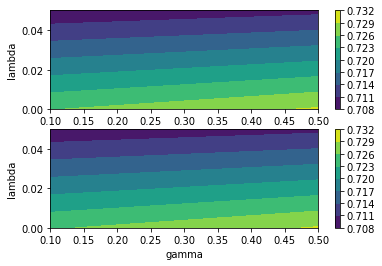

Test score for optimised parameters: 0.728980


(0.0, 0.5, 0.72898)

In [14]:
lambdas=np.array([0, 0.05])
gammas=np.array([0.1, 0.5])
w_ini=np.zeros((x_der_train.shape[1],1))
crossval_grid(x_der_train, y_train, x_der_test, y_test, 4, lambdas, gammas, w_ini, 1000, 42, 50)

lambda: 0.000000, opt. gamma: 0.100000
Current iteration=0, loss=0.6931471605599454
Current iteration=100, loss=0.6532634649230142
Current iteration=200, loss=0.6507559045067381
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.6525087568622007
Current iteration=200, loss=0.6500155367900313
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.6536589794414303
Current iteration=200, loss=0.65122835756426
Current iteration=0, loss=0.6931471605599455
Current iteration=100, loss=0.6530468834650626
Current iteration=200, loss=0.6505877603748084
lambda: 0.000000, gamma: 0.100000, training score: 0.660497, test score: 0.660330
lambda: 0.000000, opt. gamma: 0.500000
Current iteration=0, loss=0.6931471605599454
Current iteration=100, loss=0.6481345458345077
Current iteration=200, loss=0.646234720917889
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.6474686604390147
Current iteration=200, loss=0.6456132867887674
Current i

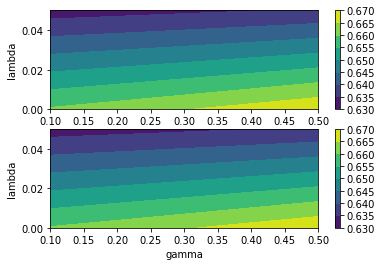

Test score for optimised parameters: 0.666200


(0.0, 0.5, 0.6662)

In [15]:
lambdas=np.array([0, 0.05])
gammas=np.array([0.1, 0.5])
w_ini=np.zeros((x_raw_train.shape[1],1))
crossval_grid(x_raw_train, y_train, x_raw_test, y_test, 4, lambdas, gammas, w_ini, 1000, 42, 50)

In [16]:
#RESOLVING 999s
y, X, ids=proj1_helpers.load_csv_data('train.csv')
y=np.expand_dims(y, axis=1)
y[y==-1]=0
tx_cleaned=unatools.resolve999values(X, 0, 0)

tx_cleaned,_,__=ml.standardise(tx_cleaned)
tx_cleaned=ml.augment_data(np.array(tx_cleaned))
x_cl_train, y_cl_train, x_cl_test, y_cl_test=ml.split_data(tx_cleaned, y, 0.8, seed=42)
x_clder_train, x_clder_test=x_cl_train[:,0:13], x_cl_test[:, 0:13]
x_clraw_train, x_clraw_test=x_cl_train[:,14:], x_cl_test[:, 14:]

Number of samples when at leas one feature has value -999: 181886
Percentage of total data:  0.727544


lambda: 0.000000, opt. gamma: 0.100000
Current iteration=0, loss=0.6931471605599454
Current iteration=100, loss=0.5259258110593067
Current iteration=200, loss=0.5161892231565685
Current iteration=300, loss=0.5119018425763955
Current iteration=400, loss=0.5092451817434136
Current iteration=500, loss=0.5074260711643919
Current iteration=600, loss=0.5061153035076529
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.5244017559357441
Current iteration=200, loss=0.5145503934835639
Current iteration=300, loss=0.5102133183810604
Current iteration=400, loss=0.5075290475933995
Current iteration=500, loss=0.5057023807616174
Current iteration=600, loss=0.5043895189479868
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.5240119668660428
Current iteration=200, loss=0.5140839198519359
Current iteration=300, loss=0.5097138054829824
Current iteration=400, loss=0.5070118706910344
Current iteration=500, loss=0.5051721186887571
Current iteration=600, loss

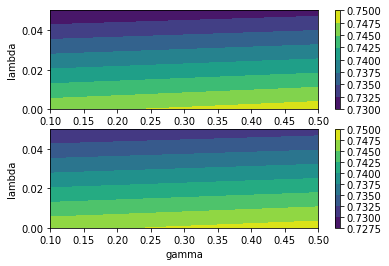

Test score for optimised parameters: 0.750040


(0.0, 0.5, 0.75004)

In [17]:
#ALL FEATURES WITH 999s REPLACED WITH FEATURE MEAN
lambdas=np.array([0, 0.05])
gammas=np.array([0.1, 0.5])
w_ini=np.zeros((x_cl_train.shape[1],1))
crossval_grid(x_cl_train, y_cl_train, x_cl_test, y_cl_test, 4, lambdas, gammas, w_ini, 1000, 42, 50)

In [18]:
max_iter=1001

lambda: 0.000000, opt. gamma: 0.100000
Current iteration=0, loss=0.6931471605599454
Current iteration=100, loss=0.5374107447345279
Current iteration=200, loss=0.532333925953335
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.535897031328473
Current iteration=200, loss=0.530728192844912
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.5352969544712184
Current iteration=200, loss=0.5300960029193942
Current iteration=0, loss=0.6931471605599455
Current iteration=100, loss=0.5345636346984732
Current iteration=200, loss=0.529238984692883
lambda: 0.000000, gamma: 0.100000, training score: 0.725255, test score: 0.725240
lambda: 0.000000, opt. gamma: 0.500000
Current iteration=0, loss=0.6931471605599454
Current iteration=100, loss=0.5304254816673202
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.5287731690057121
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.528075226933317
Current itera

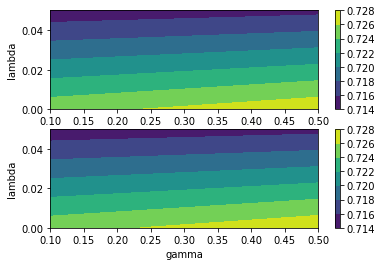

Test score for optimised parameters: 0.726960


(0.0, 0.5, 0.72696)

In [19]:
#DERIVED FEATURES WITH 999s REPLACED WITH FEATURE MEAN
lambdas=np.array([0, 0.05])
gammas=np.array([0.1, 0.5])
w_ini=np.zeros((x_clder_train.shape[1],1))
crossval_grid(x_clder_train, y_cl_train, x_clder_test, y_cl_test, 4, lambdas, gammas, w_ini, max_iter, 42, 50)

lambda: 0.000000, opt. gamma: 0.100000
Current iteration=0, loss=0.6931471605599454
Current iteration=100, loss=0.6560252552951108
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.655008978310564
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.6563107894187328
Current iteration=0, loss=0.6931471605599455
Current iteration=100, loss=0.6556482059041631
lambda: 0.000000, gamma: 0.100000, training score: 0.668172, test score: 0.668160
lambda: 0.000000, opt. gamma: 0.500000
Current iteration=0, loss=0.6931471605599454
Current iteration=0, loss=0.6931471605599456
Current iteration=0, loss=0.6931471605599456
Current iteration=0, loss=0.6931471605599455
lambda: 0.000000, gamma: 0.500000, training score: 0.671140, test score: 0.671125
lambda: 0.050000, opt. gamma: 0.100000
Current iteration=0, loss=0.6931471605599454
Current iteration=0, loss=0.6931471605599456
Current iteration=0, loss=0.6931471605599456
Current iteration=0, loss=0.693147160

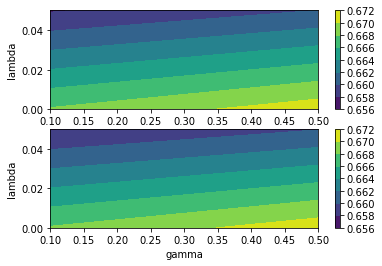

Test score for optimised parameters: 0.666800


(0.0, 0.5, 0.6668)

In [20]:
#RAW FEATURES WITH 999s REPLACED WITH FEATURE MEAN
lambdas=np.array([0, 0.05])
gammas=np.array([0.1, 0.5])
w_ini=np.zeros((x_clraw_train.shape[1],1))
crossval_grid(x_clraw_train, y_cl_train, x_clraw_test, y_cl_test, 4, lambdas, gammas, w_ini, max_iter, 42, 50)

In [21]:
# RESOLVING 999s AND REMOVING OUTLIERS
y, X, ids=proj1_helpers.load_csv_data('train.csv')
y=np.expand_dims(y, axis=1)
y[y==-1]=0
tx_cleaned=unatools.resolve999values(X, 0, 0)
tx_cleaned=unatools.removeOutliers(tx_cleaned, 95)

tx_cleaned,_,__=ml.standardise(tx_cleaned)
tx_cleaned=ml.augment_data(np.array(x))
x_cl_train, y_cl_train, x_cl_test, y_cl_test=ml.split_data(tx_cleaned, y, 0.8, seed=42)

Number of samples when at leas one feature has value -999: 181886
Percentage of total data:  0.727544


lambda: 0.000000, opt. gamma: 0.100000
Current iteration=0, loss=0.6931471605599454
Current iteration=100, loss=0.5327855557850758
Current iteration=200, loss=0.5208514935586713
Current iteration=300, loss=0.5149315251221098
Current iteration=400, loss=0.511005906437574
Current iteration=500, loss=0.5082156913605026
Current iteration=600, loss=0.5061656769478793
Current iteration=700, loss=0.5046245219629704
Current iteration=800, loss=0.5034450472049325
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.5314263731990185
Current iteration=200, loss=0.5194832312923232
Current iteration=300, loss=0.5135738810494963
Current iteration=400, loss=0.5096809022339907
Current iteration=500, loss=0.5069195866949966
Current iteration=600, loss=0.5048835550957849
Current iteration=700, loss=0.5033482137951738
Current iteration=800, loss=0.5021704758758424
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.530858902327154
Current iteration=200, loss=0

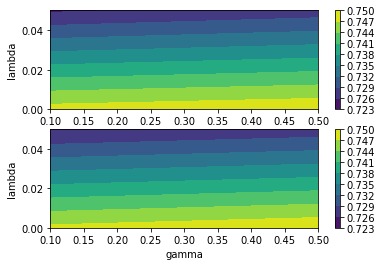

Test score for optimised parameters: 0.748760


(0.0, 0.5, 0.74876)

In [22]:
#ALL FEATURES WITH 999s REPLACED WITH FEATURE MEAN AND OUTLIERS REMOVED
lambdas=np.array([0, 0.05])
gammas=np.array([0.1, 0.5])
w_ini=np.zeros((x_cl_train.shape[1],1))
crossval_grid(x_cl_train, y_cl_train, x_cl_test, y_cl_test, 4, lambdas, gammas, w_ini, max_iter, 42, 50)

In [23]:
#RESOLVING 999s, REMOVING OUTLIERS AND REMOVING FEATURES WITH MORE THAN 50% OF MISSING VALUES
y, X, ids=proj1_helpers.load_csv_data('train.csv')
y=np.expand_dims(y, axis=1)
y[y==-1]=0
toremove=np.array([28, 27, 26, 12, 6, 5, 4])
X_cleaned=np.delete(X, toremove, axis=1)
tx_cleaned=unatools.resolve999values(X_cleaned, 0, 0)

tx_cleaned,_,__=ml.standardise(tx_cleaned)
tx_cleaned=ml.augment_data(np.array(tx_cleaned))
x_cl_train, y_cl_train, x_cl_test, y_cl_test=ml.split_data(tx_cleaned, y, 0.8, seed=42)
x_clder_train, x_clder_test=x_cl_train[:,0:13], x_cl_test[:, 0:13]
x_clraw_train, x_clraw_test=x_cl_train[:,14:], x_cl_test[:, 14:]

Number of samples when at leas one feature has value -999: 111904
Percentage of total data:  0.447616


lambda: 0.000000, opt. gamma: 0.100000
Current iteration=0, loss=0.6931471605599454
Current iteration=100, loss=0.5413041611738919
Current iteration=200, loss=0.5317069158909409
Current iteration=300, loss=0.5275818974255869
Current iteration=400, loss=0.5250530691226641
Current iteration=500, loss=0.5233341879756259
Current iteration=600, loss=0.5221010366405844
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.5396995005603111
Current iteration=200, loss=0.5300219631840467
Current iteration=300, loss=0.5258658389840956
Current iteration=400, loss=0.5233195448318478
Current iteration=500, loss=0.5215900367239487
Current iteration=600, loss=0.520350185466219
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.5390937105465328
Current iteration=200, loss=0.5293581408020603
Current iteration=300, loss=0.5251965875768413
Current iteration=400, loss=0.5226504495922375
Current iteration=500, loss=0.5209190146485818
Current iteration=600, loss=

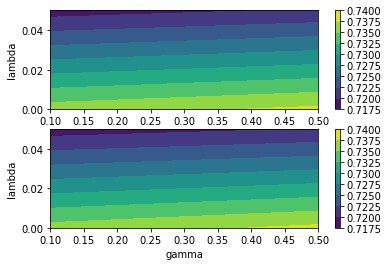

Test score for optimised parameters: 0.738340


(0.0, 0.5, 0.73834)

In [24]:
#ALL FEATURES WITH >50% of 999s REMOVED, OTHER -999s REPLACED WITH FEATURE MEAN AND OUTLIERS REMOVED
lambdas=np.array([0, 0.05])
gammas=np.array([0.1, 0.5])
w_ini=np.zeros((x_cl_train.shape[1],1))
crossval_grid(x_cl_train, y_cl_train, x_cl_test, y_cl_test, 4, lambdas, gammas, w_ini, max_iter, 42, 50)

In [25]:
#RESOLVING 999s, REMOVING OUTLIERS AND REMOVING FEATURES WITH MORE THAN 25% OF MISSING VALUES
y, X, ids=proj1_helpers.load_csv_data('train.csv')
y=np.expand_dims(y, axis=1)
y[y==-1]=0
toremove=np.array([28, 27, 26, 25, 24, 23, 12, 6, 5, 4])
X_cleaned=np.delete(X, toremove, axis=1)
tx_cleaned=unatools.resolve999values(X_cleaned, 0, 0)

tx_cleaned,_,__=ml.standardise(tx_cleaned)
tx_cleaned=ml.augment_data(np.array(tx_cleaned))
x_cl_train, y_cl_train, x_cl_test, y_cl_test=ml.split_data(tx_cleaned, y, 0.8, seed=42)
x_clder_train, x_clder_test=x_cl_train[:,0:13], x_cl_test[:, 0:13]
x_clraw_train, x_clraw_test=x_cl_train[:,14:], x_cl_test[:, 14:]

Number of samples when at leas one feature has value -999: 38114
Percentage of total data:  0.152456


lambda: 0.000000, opt. gamma: 0.100000
Current iteration=0, loss=0.6931471605599454
Current iteration=100, loss=0.5413129576878397
Current iteration=200, loss=0.5318191290095968
Current iteration=300, loss=0.5277480302597912
Current iteration=400, loss=0.5252206202366461
Current iteration=500, loss=0.5234797909833458
Current iteration=600, loss=0.5222203586799523
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.5396863146382925
Current iteration=200, loss=0.53010487575437
Current iteration=300, loss=0.5260025053264754
Current iteration=400, loss=0.5234576244361329
Current iteration=500, loss=0.521705464518595
Current iteration=600, loss=0.5204381303742305
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.5390979536529179
Current iteration=200, loss=0.5294664726168244
Current iteration=300, loss=0.5253588744706668
Current iteration=400, loss=0.5228127579705059
Current iteration=500, loss=0.5210573739014637
Current iteration=600, loss=0.

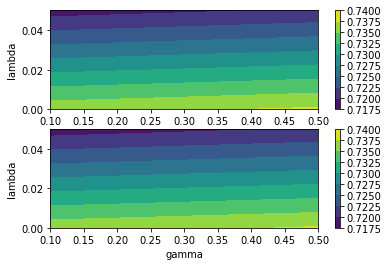

Test score for optimised parameters: 0.738780


(0.0, 0.5, 0.73878)

In [26]:
#ALL FEATURES WITH >25% of 999s REMOVED, OTHER -999s REPLACED WITH FEATURE MEAN AND OUTLIERS REMOVED
lambdas=np.array([0, 0.05])
gammas=np.array([0.1, 0.5])
w_ini=np.zeros((x_cl_train.shape[1],1))
crossval_grid(x_cl_train, y_cl_train, x_cl_test, y_cl_test, 4, lambdas, gammas, w_ini, max_iter, 42, 50)

In [27]:
#RESOLVING 999s, REMOVING OUTLIERS AND REMOVING FEATURES WITH MORE THAN 25% OF MISSING VALUES AND APPLYING SKEWNESS TRANSFORM
from tools_PT import skewness_correction
y, X, ids=proj1_helpers.load_csv_data('train.csv')
y=np.expand_dims(y, axis=1)
y[y==-1]=0
toremove=np.array([28, 27, 26, 25, 24, 23, 12, 6, 5, 4])
X_cleaned=np.delete(X, toremove, axis=1)
tx_cleaned=unatools.resolve999values(X_cleaned, 0, 0)
tx_cleaned=skewness_correction(tx_cleaned)

tx_cleaned,_,__=ml.standardise(tx_cleaned)
tx_cleaned=ml.augment_data(np.array(tx_cleaned))
x_cl_train, y_cl_train, x_cl_test, y_cl_test=ml.split_data(tx_cleaned, y, 0.8, seed=42)
x_clder_train, x_clder_test=x_cl_train[:,0:13], x_cl_test[:, 0:13]
x_clraw_train, x_clraw_test=x_cl_train[:,14:], x_cl_test[:, 14:]

Number of samples when at leas one feature has value -999: 38114
Percentage of total data:  0.152456


lambda: 0.000000, opt. gamma: 0.100000
Current iteration=0, loss=0.6931471605599454
Current iteration=100, loss=0.5378443771630791
Current iteration=200, loss=0.5338456904804866
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.5362009119390669
Current iteration=200, loss=0.5321701206285617
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.5356293633054748
Current iteration=200, loss=0.5315550208189327
Current iteration=0, loss=0.6931471605599455
Current iteration=100, loss=0.5338095918161018
Current iteration=200, loss=0.5296197885297979
lambda: 0.000000, gamma: 0.100000, training score: 0.723172, test score: 0.723230
lambda: 0.000000, opt. gamma: 0.500000
Current iteration=0, loss=0.6931471605599454
Current iteration=100, loss=0.5310817511958115
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.529470180697416
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.5288089446875137
Current i

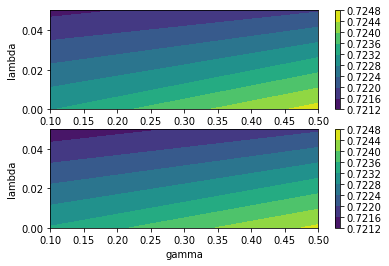

Test score for optimised parameters: 0.723060


(0.0, 0.5, 0.72306)

In [28]:
#ALL FEATURES WITH >25% of 999s REMOVED, OTHER -999s REPLACED WITH FEATURE MEAN AND OUTLIERS REMOVED AND SKEWNESS TRANSFORM
lambdas=np.array([0, 0.05])
gammas=np.array([0.1, 0.5])
w_ini=np.zeros((x_cl_train.shape[1],1))
crossval_grid(x_cl_train, y_cl_train, x_cl_test, y_cl_test, 4, lambdas, gammas, w_ini, max_iter, 42, 50)

Correlations:
    0 - 2 (linear)
    4 - 5 (linear)
    4 - 6 (nonlinear)
    5 - 6 (nonlinear)
    9 - 23 (linear)
    9 - 29 (linear)
    23 - 29 (linear)
    
To remove correlated features and keep max information we should remove 0, 4, 9, 23. BUT 4 and 23 are features with 25% or more -999s
So compared to last step, we only need to remove 0 and 9
    

In [29]:
#RESOLVING 999s, REMOVING OUTLIERS AND REMOVING FEATURES WITH MORE THAN 25% OF MISSING VALUES AND APPLYING SKEWNESS TRANSFORM AND REMOVING CORRELATED FEATURES
from tools_PT import skewness_correction
y, X, ids=proj1_helpers.load_csv_data('train.csv')
y=np.expand_dims(y, axis=1)
y[y==-1]=0
toremove=np.array([28, 27, 26, 25, 24, 23, 12,9, 6, 5, 4,0])
X_cleaned=np.delete(X, toremove, axis=1)
tx_cleaned=unatools.resolve999values(X_cleaned, 0, 0)
tx_cleaned=skewness_correction(tx_cleaned)

tx_cleaned,_,__=ml.standardise(tx_cleaned)
tx_cleaned=ml.augment_data(np.array(tx_cleaned))
x_cl_train, y_cl_train, x_cl_test, y_cl_test=ml.split_data(tx_cleaned, y, 0.8, seed=42)
x_clder_train, x_clder_test=x_cl_train[:,0:13], x_cl_test[:, 0:13]
x_clraw_train, x_clraw_test=x_cl_train[:,14:], x_cl_test[:, 14:]

Number of samples when at leas one feature has value -999: 0
Percentage of total data:  0.0


lambda: 0.000000, opt. gamma: 0.100000
Current iteration=0, loss=0.6931471605599454
Current iteration=100, loss=0.5388875201004125
Current iteration=200, loss=0.5348800416585431
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.5372928083124879
Current iteration=200, loss=0.533255378989651
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.5365959110974027
Current iteration=200, loss=0.5325019656617641
Current iteration=0, loss=0.6931471605599455
Current iteration=100, loss=0.5348633524654572
Current iteration=200, loss=0.53064699010839
lambda: 0.000000, gamma: 0.100000, training score: 0.722430, test score: 0.722340
lambda: 0.000000, opt. gamma: 0.500000
Current iteration=0, loss=0.6931471605599454
Current iteration=100, loss=0.5323487786442594
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.5308117561451106
Current iteration=0, loss=0.6931471605599456
Current iteration=100, loss=0.5299698611523547
Current ite

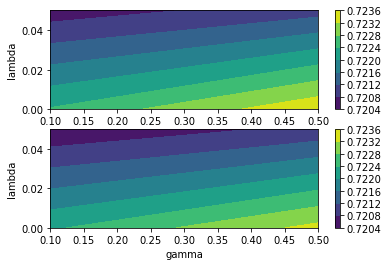

Test score for optimised parameters: 0.722620


(0.0, 0.5, 0.72262)

In [30]:
#ALL FEATURES WITH >25% of 999s REMOVED, OTHER -999s REPLACED WITH FEATURE MEAN AND OUTLIERS REMOVED AND SKEWNESS TRANSFORM AND REMOVING CORRELATED FEATURES
lambdas=np.array([0, 0.05])
gammas=np.array([0.1, 0.5])
w_ini=np.zeros((x_cl_train.shape[1],1))
crossval_grid(x_cl_train, y_cl_train, x_cl_test, y_cl_test, 4, lambdas, gammas, w_ini, max_iter, 42, 50)

In [5]:
from tools_PT import skewness_correction

y, X, ids=proj1_helpers.load_csv_data('train.csv')
y=np.expand_dims(y, axis=1)
y, X, ids=proj1_helpers.load_csv_data('train.csv')
y=np.expand_dims(y, axis=1)
toremove=np.array([28, 27, 26, 25, 24, 23, 12,9, 6, 5, 4,0])
X_cleaned=np.delete(X, toremove, axis=1)
tx_cleaned=unatools.resolve999values(X_cleaned, 0, 0)
tx_cleaned=skewness_correction(tx_cleaned)
test=unatools.build_poly(tx_cleaned, 1,1,2)

Number of samples when at leas one feature has value -999: 0
Percentage of total data:  0.0


TypeError: build_poly_degree() takes 2 positional arguments but 4 were given

In [ ]:
test.shape

In [7]:
y[y==-1]=0

In [8]:
y

array([[1.],
       [0.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]])